As more people tweet to companies, it is imperative for companies to parse through the many tweets that are coming in, to figure out what people want and to quickly deal with upset customers. Machine learning can help to facilitate this. In this notebook, I'll examine a dataset of ~14,000 tweets directed at various airlines. The algorithm I'm choosing to use is [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA), primarily because it is interpretable and learns in an unsupervised manner.

In this post, I'll clean, model, and visualize the tweets. These visualizations will act as a hypothesis-generating tool for comparing airlines against each other. Let's get started.

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import seaborn as sns

### First, load the data

In [3]:
kagTweets = pd.read_csv('kaggleTweets.csv')

### Now, let's look at an overview of the data

In [4]:
airCounts = dict(Counter(kagTweets['airline']))

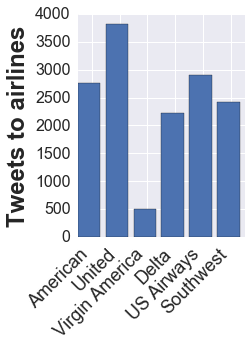

In [5]:
fig = plt.figure(figsize=(3,4), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(len(airCounts)),airCounts.values())#,color=[c[4],c[4],c[3],c[3]])
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(len(airCounts.keys()))],airCounts.keys(),rotation=45,ha='right',fontsize=18)
ax.set_ylabel('Tweets to airlines',fontsize=24,fontweight='bold')

yTix = plt.yticks()[0]
plt.yticks(yTix,fontsize=16)

plt.show()

### The airlines have a varying amount of tweets each. Now, let's take a look at a tweet

In [6]:
kagTweets['text'][136]

'@virginamerica you ROCK for making it so I can watch #Oscars on my flight!! #redcarpet #oscars #oscars2015'

### A need to standardize

Like anything in machine learning, the power of algorithms are realized when the data are translated into meaningful features. Simply splitting the strings by spaces is insufficient. Here are several things to note, along with the strategy to address each of them:

1. word capitalization (string class functions)
2. punctuation (regular expressions)
3. singular-plural versions of same word (lemmatization)
4. common words like 'and' (stopwords)

Cleaning up the data is one of the main challenges of text analysis. We will use the `NLTK` and `re` packages to clean the text and `gensim` to implement various learning algorithms

In [7]:
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.utils import SaveLoad
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from re import sub
import pyLDAvis.gensim
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from wordcloud import WordCloud
from sklearn.utils import resample

### Functionalized text cleaning

These are a bunch of pre-processing functions to to standardize the text one word at a time. 

In [8]:
#Functions for data cleaning
wnl = WordNetLemmatizer()

def removePunc(myWord):
    """Function to remove punctuation from string inputs"""
    if myWord is None:
        return myWord
    else:
        return sub('[.:;()/!&-*@$,?^\d+]','',myWord)
        
def removeAscii(myWord):
    """Function to remove ascii from string input"""
    if myWord is None:
        return myWord
    else:
        return str(sub(r'[^\x00-\x7F]+','', myWord.decode('utf-8').strip()))

def lemmatize(myWord):
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return str(wnl.lemmatize(myWord))

def removeStopWords(myWord):
    """Function to remove stop words"""
    if myWord is None:
        return myWord
    if myWord not in str(stopwords.words('english')):
        return myWord

def removeLinkUser(myWord):
    """Function to remove web addresses and twitter handles"""
    if not myWord.startswith('@') and not myWord.startswith('http'):
        return myWord

def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(
            removeAscii(
                removePunc(
                    removeLinkUser(
                        myWord.lower()
                    )
                )
            )
        )
    )


### Putting it all together

Now that we have all the cleaning steps, we can apply them across all tweets. Here's a function that does exactly this.

In [9]:
def filterTweetList(tweetList):
    """Remove stop words, lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]

In [10]:
cleanKagTweetList = filterTweetList(kagTweets['text'])

### A second look

Now that we've cleaned our tweets, let's revisit our first example

In [11]:
cleanKagTweetList[136]

['rock',
 'making',
 'watch',
 '#oscars',
 'flight',
 '#redcarpet',
 '#oscars',
 '#oscars']

#### Now the data are ready for processing.

Many algorithms use a similar initial format, which is to
1. Build a dictionary with all words in the dataset
2. Store the word counts (using above dictionary) of each tweet in a corpus

Note that in `step 2` only the word frequency is used. This is a so-called "bag-of-words" approach, which does not account for ordering of words next to each other. Other analyses like bigrams or trigrams could be used if word ordering was highly conserved.

Because I am looking at unlabeled data, and I want to get intuition for the data, I chose to use [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA), a topic modeling approach that probablistically learns the latent (unobserved) topics of a group of documents. There are a couple other algorithms, like LSA, LSI, or TF-IDF, which were either less accurate at predicting similarity or more suited to supervised learning.

#### Next, build the functions for making the dictionary, corpus, and the LDA model

In [12]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

### Building models and notes on parameter choices

Below I'm using some pre-generated dictionaries and libraries. This saves substantial computing time. If running this for the first time, run the commented code instead.

Note in the `createLDA` function, I'n using an `alpha` parameter of `0.001` and `50` `topics`. The low number for `alpha` corresponds to a low number of topics per tweet, since tweets are relatively very short. While increasing the numper of `topics` decreases the `log perplexity`, an error metric, I found that this makes it more difficult in interpreting the data. `50` seems to be a good compromise between optimizing accuracy and interpretability.


In [13]:
kagLda = SaveLoad.load('kaggleLDAmodel0201')
kagDict = corpora.Dictionary.load('kaggleDictionary0201.dict')
kagCorpus = corpora.MmCorpus('kaggleCorpus0201.mm')

#"""Create model objects"""
#kagDict   = makeDict(cleanKagTweetList)
#kagCorpus = makeCorpus(cleanKagTweetList, kagDict)
#kagLda = createLDA(kagCorpus, kagDict)

#"""Save model objects"""
#SaveLoad.save(kagLda,'kaggleLDAmodel')
#corpora.MmCorpus.serialize('kaggleCorpus.mm', kagCorpus)
#kagDict.save('kaggleDictionary.dict')

#### Having built the LDA model
we can visualize our results using the `pyLDAvis` package. The plot is interactive, try it out! Each circle is a topic and the size represents the abundance of that topic in the corpus. Along with each topic are the associated words that go with it. There's a [great video](https://www.youtube.com/watch?v=tGxW2BzC_DU&index=4&list=PLykRMO7ZuHwP5cWnbEmP_mUIVgzd5DZgH) about this as well. 

In [14]:
pyLDAvis.enable_notebook()
ldaViz = pyLDAvis.gensim.prepare(kagLda, kagCorpus, kagDict)

# Topic visualization of airline tweets using LDA

In [15]:
ldaViz

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
43     4.867959        1       1 -0.217131  0.110123
11     3.939707        1       2  0.162362  0.006647
15     3.558634        1       3 -0.097500 -0.112141
30     3.237907        1       4 -0.097969  0.152709
48     2.815271        1       5 -0.088332  0.148928
10     2.654464        1       6 -0.129438 -0.083498
28     2.585804        1       7 -0.074824 -0.186904
8      2.443367        1       8 -0.071265 -0.036302
45     2.432573        1       9 -0.098841  0.023151
37     2.423856        1      10 -0.125846 -0.018179
17     2.387313        1      11 -0.025140  0.172635
9      2.239750        1      12  0.049907 -0.088598
18     2.216934        1      13  0.048592 -0.020624
21     2.125084        1      14 -0.039796 -0.043180
13     2.105937        1      15  0.108033 -0.042968
2      2.094284        1      16 -0.075765  0.005730
47     2.057171        1      17 -0.017693 -0.000526
41     2.004455        1      18 -0.126196 -0.033681
25     1.919174        1      19 -0.005185 -0.000166
20     1.878136        1      20  0.057458 -0.003942
16     1.858807        1      21  0.123010  0.006783
23     1.854649        1      22 -0.066475 -0.027684
1      1.845774        1      23  0.097129 -0.000407
33     1.821435        1      24 -0.034077 -0.081206
14     1.779760        1      25  0.073096  0.085524
7      1.767292        1      26  0.048888  0.023509
39     1.762897        1      27 -0.003061 -0.017747
34     1.707820        1      28 -0.030323  0.046933
38     1.667528        1      29  0.082197 -0.092613
0      1.651820        1      30  0.062485 -0.003084
19     1.648362        1      31  0.061855  0.056206
49     1.645764        1      32  0.139966  0.066548
6      1.643111        1      33  0.116791  0.032209
26     1.642041        1      34 -0.030421 -0.061213
35     1.635494        1      35  0.050542 -0.017382
12     1.614172        1      36  0.082965 -0.061536
31     1.602999        1      37 -0.067829 -0.056175
22     1.579977        1      38  0.045724  0.042226
4      1.573105        1      39 -0.086490  0.026538
5      1.539325        1      40 -0.022125  0.005764
46     1.492677        1      41  0.017348 -0.019600
29     1.476745        1      42 -0.017237 -0.043245
3      1.463816        1      43  0.097339  0.040587
27     1.455830        1      44  0.066595 -0.047743
40     1.451135        1      45 -0.024330 -0.009605
24     1.434576        1      46  0.076260  0.025997
36     1.420578        1      47 -0.028576 -0.021227
42     1.391198        1      48  0.010724  0.100856
44     1.357080        1      49 -0.013470  0.092798
32     1.226455        1      50  0.036066 -0.041227, topic_info=      Category         Freq         Term  Total  loglift  logprob
7167   Default   601.000000        thank    601  30.0000  30.0000
1837   Default   976.000000      service    976  29.0000  29.0000
3682   Default  1066.000000       thanks   1066  28.0000  28.0000
2495   Default   917.000000     customer    917  27.0000  27.0000
7525   Default  1048.000000    cancelled   1048  26.0000  26.0000
11598  Default  4494.000000       flight   4494  25.0000  25.0000
1253   Default   502.000000    flightled    502  24.0000  24.0000
7986   Default   423.000000         late    423  23.0000  23.0000
8108   Default   755.000000          bag    755  22.0000  22.0000
805    Default   344.000000       minute    344  21.0000  21.0000
10355  Default   216.000000      jetblue    216  20.0000  20.0000
8226   Default   555.000000       please    555  19.0000  19.0000
3087   Default   308.000000      problem    308  18.0000  18.0000
8736   Default   253.000000           dm    253  17.0000  17.0000
3669   Default   369.000000          min    369  16.0000  16.0000
11941  Default   362.000000      waiting    362  15.0000  15.0000
11077  Default   232.000000        worst    232  14.0000  14.0000
2446   Defaul

### Visualization-guided analysis

After finding a topic of interest, we can find sort the data based on this topic for further information on which airline got the most tweets in a given topic. To do this, we first need to match the indices between the visualization and our LDA model.

In [16]:
def translateLdaIdx(myLdaModel, myLdaViz):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    ldaVizIdx = myLdaViz[0].index
    return list(ldaVizIdx)

In [17]:
newIdx = translateLdaIdx(kagLda,ldaViz)

### Now, having matched the model indices
translate the corpus to a Pandas dataframe

In [18]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    """Transform corpus to dataframe with topics matching lda visualization"""
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['topic' + str(i + 1) for i in range(numTopics)]
    return mySortedDf

In [19]:
kagDf = createDenseMat(kagLda,kagCorpus,newIdx)

### Functions for sorting according to threshold

In [20]:
def sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    """Returns an index of tweets surpassing a topic value threshold"""
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    return srtIdx

def sortTweetsByIdx(cleanedTweetList,srtIdx):
    """Returns sorted tweets as a list based on a defined sort index"""
    myCleanArray = np.array(cleanedTweetList)
    srtTweets = list(myCleanArray[srtIdx])
    return srtTweets

In [21]:
sortedIdx = sortByTopicToIdx(cleanKagTweetList,kagDf,'topic2',myTopicThresh=0.1)

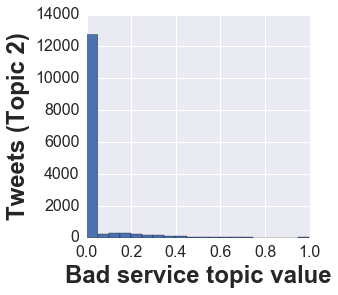

In [22]:
fig = plt.figure(figsize=(4,4), dpi=1600)
ax = plt.subplot(111)
plt.hist(kagDf.topic2,bins=20)

ax.tick_params(labelsize=16)
ax.set_xlabel('Bad service topic value',fontsize=24,fontweight='bold')
ax.set_ylabel('Tweets (Topic 2)',fontsize=24,fontweight='bold')
plt.show()
x = fig.tight_layout()
#fig.savefig('passingFilterTweets.png',dpi=500,bbox_inches='tight')

#### The distribution of bad service tweets
shows that only a small fraction of tweets have a bad service topic component. There appear to be two peaks; one at `0` and one at `0.1`. Sorting for tweets with Topic 2 > 0.1 would separate the second population.

We can visualize the words in these tweets with a word cloud to verify the visualization results.

#### Visualize topic 2 with a word cloud

In [23]:
def makeWordCloud(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    """Create word cloud of tweets passing a given threshold for a given topic"""
    sortedIdx = sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1)
    mySortedTweets = sortTweetsByIdx(cleanedTweetList,sortedIdx)
    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
    myTopicCloud = WordCloud(max_font_size=100,scale=8).generate(filteredWords)
    fig = plt.figure(figsize=(10,10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")
    plt.show()

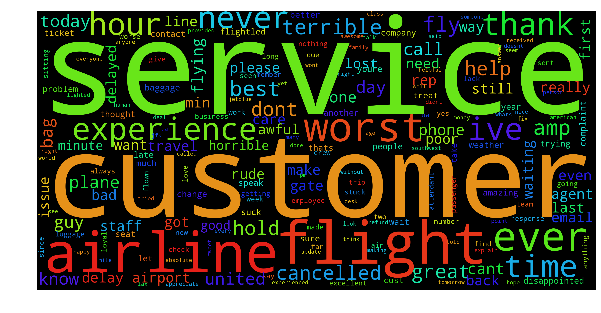

In [25]:
makeWordCloud(cleanKagTweetList,kagDf,'topic2',myTopicThresh=0.2)

### Using tweets to rank industry competitors

We can count how many tweets each company received, perhaps this could give some intuition about which airline has the actual best customer service.

In order to have more reliable data, we will

1. normalize the tweets to the total number of tweets for each company
2. estimate the error by using 95% confidence intervals generated from bootstap resampling

#### First, the resampling function

In [26]:
def genSortedResample(myTweetDf,myIdx,myVar='airline'):
    """Resample sorted airline counts to estimate error. Return as pd.Dataframe"""
    airlinePop = np.array(myTweetDf.loc[myIdx][myVar])
    len(airlinePop)
    #Counter(resample(airlinePop))
    airlineNames = list(np.unique(myTweetDf[myVar]))
    testDf=pd.DataFrame(columns=airlineNames)
    for i in range(1000):
        tempSample = pd.Series(dict(Counter(resample(airlinePop))))
        testDf = testDf.append(tempSample,ignore_index=True)
    totalAirTweets = dict(Counter(myTweetDf[myVar]))
    for i in totalAirTweets.keys():
        normVal = testDf[i]/float(totalAirTweets[i])
        testDf[i + '-norm'] = pd.Series(normVal,index=testDf.index)
    return testDf

In [27]:
sortedIdx = sortByTopicToIdx(cleanKagTweetList,kagDf,'topic2',myTopicThresh=0.1)
airlineDistResample = genSortedResample(kagTweets,sortedIdx)

#### Next, a function to calculate the 95% confidence intervals

In [28]:
def getResampleStats(resampleDf,airlineNames):
    """Extract expected value and 95% CI values from resampling dataframe"""
    statDf = pd.DataFrame(columns=['mean','low95','hi95'])
    for airline in airlineNames:
        tempName = airline + '-norm'
        tempSort = np.sort(resampleDf[tempName])
        meanVal = np.mean(tempSort)
        low95 = meanVal - tempSort[24] 
        hi95 = tempSort[975] - meanVal
        statDf = statDf.append({'mean': meanVal,'low95':low95,'hi95':hi95},ignore_index=True)

    statDf.index = airlineNames
    statDf = statDf.sort_values('mean')
    statDf = statDf/statDf.iloc[0]['mean']
    return statDf

In [29]:
def calcAirlineStats(cleanedTweetList,mySortedDf,myTopic,myTweetDf,myTopicThresh=0.1):
    """Generate mean and 95% CI given a topic and threshold"""
    sortedIdx = sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1)
    mySortedTweets = sortTweetsByIdx(cleanedTweetList,sortedIdx)
    myResample = genSortedResample(myTweetDf,sortedIdx)
    myStats = getResampleStats(myResample,list(set(kagTweets['airline'])))
    return myStats

In [30]:
statDf = calcAirlineStats(cleanKagTweetList,kagDf,'topic2',kagTweets)

### Sizing up the competition

How do the airlines stack up? Having the summary stats, let's take a look

In [31]:
c = sns.color_palette('Set3',10)
sns.set_style("ticks")

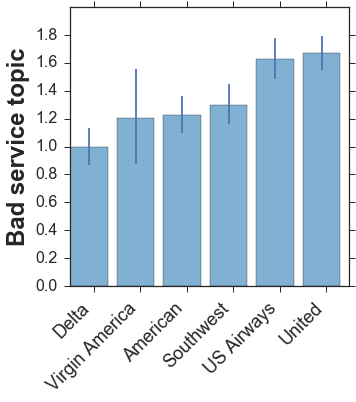

In [32]:
fig = plt.figure(figsize=(5,5), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(6),statDf.loc[:,'mean'],yerr=[list(statDf.loc[:,'low95']),list(statDf.loc[:,'hi95'])], \
                  #alpha=1,color=[c[4],c[8],c[4],c[8],c[3],c[3]])
                  #alpha=1,color=[c[8],c[8],c[8],c[8],c[8],c[8]])
                  alpha=1,color=[c[4],c[4],c[4],c[4],c[4],c[4]])
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],list(statDf.index),rotation=45,ha='right',fontsize=18)
ax.set_ylabel('Bad service topic',fontsize=24,fontweight='bold')
yTix = plt.yticks()[0]
plt.yticks(plt.yticks()[0],fontsize=16)

plt.ylim([0,2])
plt.show()
#fig.savefig('airlineBadServiceNoColor.png',dpi=500,bbox_inches='tight')

### The data speak

The data show that United and US Airways have a significantly higher proportion of tweets about bad customer service than Delta, Virgin, or American. 

Does this match your experience? To check if this result made sense I referenced a [J.D. Power North American Airline Survey](http://www.jdpower.com/press-releases/2015-north-america-airline-satisfaction-study) of customer satisfaction.

In [33]:
statDf = calcAirlineStats(cleanKagTweetList,kagDf,'topic2',kagTweets)

In [34]:
# J.D. Power data
jdAirline = {'Delta': 706, 'American': 700,'United': 665,'US Airways': 668,}

In [35]:
jdDf = pd.DataFrame(columns=['airline','value'])
for airline in jdAirline.keys():
    jdDf = jdDf.append(pd.Series({'airline':airline,'value': jdAirline[airline]}),ignore_index=True)

jdDf = jdDf.iloc[[3,0,1,2]]   
jdDf.loc[:,'relativeValue'] = (jdDf['value']-691)

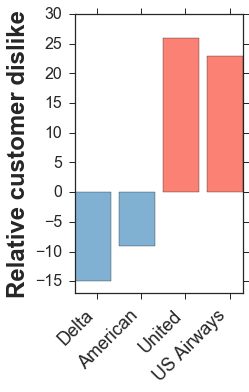

In [36]:
fig = plt.figure(figsize=(3,5), dpi=1600)
ax = plt.subplot(111)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],list(jdDf.airline),rotation=45,ha='right',fontsize=18)
ax.set_ylabel('Relative customer dislike',fontsize=24,fontweight='bold')
ax = plt.bar(range(len(jdDf)),-jdDf['relativeValue'],color=[c[4],c[4],c[3],c[3]])

yTix = plt.yticks()[0]
plt.yticks(yTix,fontsize=16)
plt.ylim([-17,30])

plt.show()
fig.savefig('jdAirlineRating.png',dpi=500,bbox_inches='tight')

### Matching rankings

As with the rankings from the bad customer service tweets, the customer satisfaction survey indicates that United and US Airways are worse than Delta and American. Topic 2, the most negative tweet, appears to be a suitable surrogate for actual surveys of customer opinions. This suggests that modeling tweets could estimate customer opinions on any topic.


# Conclusions and future directions

Applying cleaning functions allowed us to translate a bunch of tweets into structured data, namely a word `dictionary` and tweet `corpus`. Then I used Latent Dirichlet Allocation to learn shared topics across the tweet `corpus`. The visualization allows users to easily scan the data for topics of interest, which can be subsequently sorted. The sorted topics then allow comparisons of competitors within an industry. In this instance, I chose to examine customer service, but the analysis should be extensible to topics, or even other media, such as messaging or online reviews.

The data I presented were using ~14,000 tweets. This analysis could be built upon in several ways. For one, increasing the number of tweets to begin with could give more robust statistics and allow filtering to contain only longer tweets or tweets with a higher topic threshold. New tweets should ideally be sampled across several time points so the data are not temporally biased by events such as uneven weather effects.

Also, this model could be used in a predictive setting, where new tweets could be sorted by similarity (using built-in `gensim` functionality) to existing tweets. For example, if a new tweet is similar to an existing tweet asking for detailed help on online booking, a company could use this to assign this interaction to an expert knowledgable in online booking.
